In [1]:
import pandas as pd

In [2]:
df = pd.read_excel('table.xlsx')

In [3]:
df.head()

,Unnamed: 0,position,article,paid per unit,amount,paid per position,reduced,original price per unit,original price per position,binding,quantity,unit,delivery_day,delivery_month,deliveryID,order-nr,add_day,add_month,pfand
0,0,1,Leimer Backerbsen,1.19,1,1.19,False,1.19,1.19,200g,200.0,g,16,9,1.pdf,806-062-0784,13,9,0.0
1,1,2,Radieschen,0.59,1,0.59,False,0.59,0.59,1 Bund,1.0,Bund,16,9,1.pdf,806-062-0784,13,9,0.0
2,2,3,Elinas Joghurt Honig Griechischer Art,1.89,1,1.89,False,1.89,1.89,4 x 150g,600.0,g,16,9,1.pdf,806-062-0784,13,9,0.0
3,3,4,Knorr Buchstaben Suppe,0.89,2,1.78,False,0.89,1.78,82g,82.0,g,16,9,1.pdf,806-062-0784,13,9,0.0
4,4,5,Knorr Hühnersuppe Nudeltopf Mix,0.89,2,1.78,False,0.89,1.78,69g,69.0,g,16,9,1.pdf,806-062-0784,13,9,0.0


In [4]:
unique_article_list = pd.unique(df['article'])

1. What are the 10 most frequent shopped items?

In [5]:
quantity_df = pd.DataFrame([(list(df.groupby('article')['amount'])[i][0], sum(list(df.groupby('article')['amount'])[i][1])) for i in range(len(unique_article_list))], columns=['article','quantity'])

<Axes: title={'center': 'the 10 most frequent ordered articles'}, xlabel='article'>

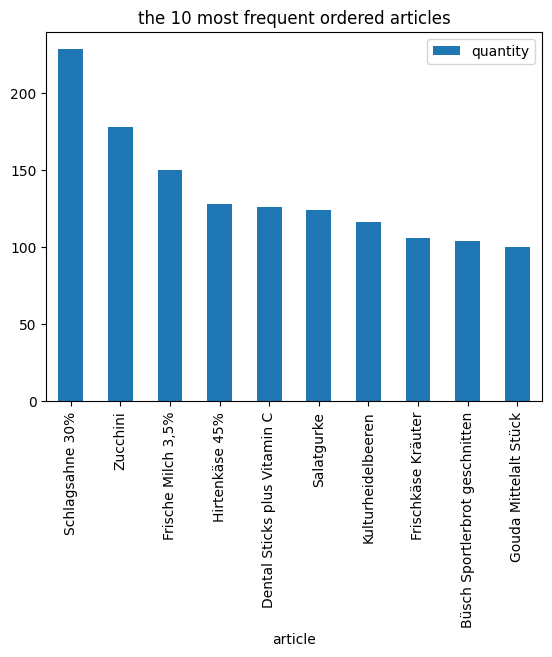

In [6]:
quantity_df.sort_values(by='quantity',ascending=False)[:10].plot(kind='bar', title='the 10 most frequent ordered articles', x='article')

2. Which items get pruchased together?

In [7]:
import numpy as np

In [8]:
mat = np.array(pd.get_dummies(df['deliveryID']).replace({True: 1, False: 0}).transpose())

In [9]:
amount = np.array(df['amount'].transpose())

In [10]:
df_new = pd.DataFrame([amount * mat[line] for line in range(mat.shape[0])]).transpose()

In [11]:
df_new['article'] = df['article']

In [12]:
df_new = df_new.groupby('article').sum().reset_index()

In [13]:
corr_df = df_new.drop('article',axis=1)

In [14]:
corr_df = corr_df.replace(0,np.nan)

In [15]:
corr_df = corr_df.transpose()

In [16]:
dfc = corr_df.corr(method='pearson',min_periods=14, numeric_only=True)

In [17]:
dfc = np.array(dfc)
for i in range(dfc.shape[0]):
    dfc[i][i] = np.nan

In [18]:
dfc = abs(pd.DataFrame(dfc))

In [19]:
dfc = dfc.drop(quantity_df.sort_values(by='quantity',ascending=False)[:10].index,axis=0)
dfc = dfc.drop(quantity_df.sort_values(by='quantity',ascending=False)[:10].index,axis=1)

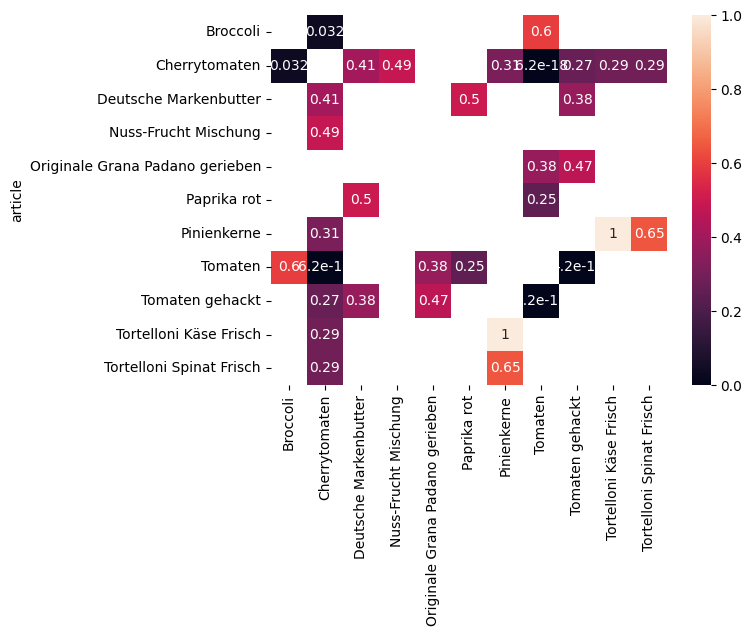

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

thresh = 0.45

ndf = pd.DataFrame(dfc.loc[dfc.max(axis=1) > thresh, dfc.max(axis=0) > thresh])
ndf['article'] = df_new['article'][quantity_df.sort_values(by='quantity',ascending=False)[10:].index].sort_index()
#ndf['article'] = df_new['article'][dfc.max(axis=1) > thresh]
ndf = ndf.set_index('article')
ndf = ndf.rename(columns=df_new['article'][quantity_df.sort_values(by='quantity',ascending=False)[10:].index].sort_index())

sns.heatmap(ndf, annot=True)
plt.show()

Häufigste Artikel [CHECK]
Welche Produkte kaufen wir meistens zusammen? [CHECK]
Wie viel Geld geben wir pro Kategorie aus?

Kategorien: Getränke, Küchenartikel, Hygieneartikel, Tierprodukte, Milchprodukte, Fleisch und Fleischprodukte, Tiefkühlprodukte, Fertigprodukte und Suppen, Sonstiges, Frisches Obst, Getreide- und Backwaren, Gemüse, Süßwaren, Snacks und Knabbereien

Einfluss auf die Einkaufsmenge eines Produktes
<br>**AV:** 
+ amount per delivery 
<br>
<br>

**UV:** 
+ reduced
+ (paid per unit - original price per unit) 
+ last_purchased
+ delivery_month: seasonal influence

In [21]:
df['amount'][quantity_df.sort_values(by='quantity',ascending=False)[:100].index].sort_index()

19     1
38     1
40     1
45     1
60     1
      ..
710    2
724    1
758    1
759    1
763    3
Name: amount, Length: 100, dtype: int64

In [22]:
df['deliveryNo'] = [int(ID.split('.')[0]) for ID in df['deliveryID']]

In [23]:
mat = np.array(pd.get_dummies(df['deliveryNo']).replace({True: 1, False: 0}).transpose())
amount = np.array(df['amount'].transpose())
df_new = pd.DataFrame([amount * mat[line] for line in range(mat.shape[0])]).transpose()
df_new['delivery'] = df['article']
df_new = df_new.groupby('delivery').sum().reset_index()
y_all = df_new.transpose()
y_all = y_all[quantity_df.sort_values(by='quantity',ascending=False)[:100].index]
y_all.columns = y_all.iloc[0]
y_all = y_all.drop('delivery', axis=0)
y_all

delivery,Schlagsahne 30%,Zucchini,"Frische Milch 3,5%",Hirtenkäse 45%,Dental Sticks plus Vitamin C,Salatgurke,Kulturheidelbeeren,Frischkäse Kräuter,Büsch Sportlerbrot geschnitten,Gouda Mittelalt Stück,...,Maggi Gemüsebrühe,Mandarinen,Gruyere AOP,"Joghurt mild 3,5%",Mini Pflaumen Tomaten,Falafel Bällchen vegan,Tante Fanny Flammkuchenteig,Lindt Excellence Mild 85% Cacao,Traubensaft,Amecke Sanfte Säfte Orange
0,2,0,0,1,0,1,1,1,1,1,...,0,0,0,0,1,1,0,0,0,0
1,0,0,0,1,0,0,1,0,1,1,...,0,0,0,0,0,0,1,0,0,0
2,0,1,1,0,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,2,0,0,1,0,1,0,2,1,0,...,0,0,0,0,0,0,0,0,0,0
4,2,0,0,1,0,1,1,1,1,1,...,0,0,0,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,0,0,0,1,0,1,0,0,0,1,...,0,1,0,0,0,1,0,0,0,0
190,0,0,0,1,0,1,0,0,0,1,...,0,1,0,0,0,1,0,0,0,0
191,0,0,0,0,2,1,1,1,0,1,...,0,0,1,0,1,0,0,0,0,0
192,1,0,2,1,0,0,0,0,0,1,...,0,1,0,0,0,0,1,0,1,0


Hier müssen nan rein, wenn artikel gar nicht in der Bestellung war, weiul wir incht wissen, ob der Artikel dort im Angebot war.

In [24]:
mat = np.array(pd.get_dummies(df['deliveryNo']).replace({True: 1, False: 0}).transpose())
reduced = np.array(df['reduced'].replace({True: 1, False: 0}).transpose())
df_new = pd.DataFrame([reduced * mat[line] for line in range(mat.shape[0])]).transpose()
df_new['delivery'] = df['article']
X_reduced = df_new.groupby('delivery').max().reset_index().transpose()
X_reduced = X_reduced[quantity_df.sort_values(by='quantity',ascending=False)[:100].index]
X_reduced.columns = X_reduced.iloc[0]
X_reduced = X_reduced.drop('delivery', axis=0)
X_reduced

delivery,Schlagsahne 30%,Zucchini,"Frische Milch 3,5%",Hirtenkäse 45%,Dental Sticks plus Vitamin C,Salatgurke,Kulturheidelbeeren,Frischkäse Kräuter,Büsch Sportlerbrot geschnitten,Gouda Mittelalt Stück,...,Maggi Gemüsebrühe,Mandarinen,Gruyere AOP,"Joghurt mild 3,5%",Mini Pflaumen Tomaten,Falafel Bällchen vegan,Tante Fanny Flammkuchenteig,Lindt Excellence Mild 85% Cacao,Traubensaft,Amecke Sanfte Säfte Orange
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
190,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
191,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
192,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [25]:
X_month = df.groupby('deliveryNo')['delivery_month'].max()

In [26]:
X_month = X_month.replace({1: 'winter',
                2: 'winter',
                3: 'winter',
                4: 'spring',
                5: 'spring',
                6: 'spring',
                7: 'summer',
                8: 'summer',
                9: 'summer',
                10: 'fall',
                11: 'fall',
                12: 'fall'})

In [27]:
X_month = pd.get_dummies(X_month).replace({True: 1, False: 0})

In [28]:
X_month.reset_index().drop('deliveryNo',axis=1)

,fall,spring,summer,winter
0,0,0,1,0
1,0,0,1,0
2,0,0,1,0
3,0,0,1,0
4,0,0,1,0
...,...,...,...,...
189,0,0,1,0
190,0,0,1,0
191,0,0,1,0
192,0,0,1,0


In [29]:
mat = np.array(pd.get_dummies(df['deliveryNo']).replace({True: 1, False: 0}).transpose())
saving = df['original price per unit'] - df['paid per unit']
df_new = pd.DataFrame([saving * mat[line] for line in range(mat.shape[0])]).transpose()
df_new['delivery'] = df['article']
X_saving = df_new.groupby('delivery').max().reset_index().transpose()
X_saving = X_saving[quantity_df.sort_values(by='quantity',ascending=False)[:100].index]
X_saving.columns = X_saving.iloc[0]
X_saving = X_saving.drop('delivery', axis=0)
X_saving

delivery,Schlagsahne 30%,Zucchini,"Frische Milch 3,5%",Hirtenkäse 45%,Dental Sticks plus Vitamin C,Salatgurke,Kulturheidelbeeren,Frischkäse Kräuter,Büsch Sportlerbrot geschnitten,Gouda Mittelalt Stück,...,Maggi Gemüsebrühe,Mandarinen,Gruyere AOP,"Joghurt mild 3,5%",Mini Pflaumen Tomaten,Falafel Bällchen vegan,Tante Fanny Flammkuchenteig,Lindt Excellence Mild 85% Cacao,Traubensaft,Amecke Sanfte Säfte Orange
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.6,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
190,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
191,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.6,0.0,0.0,0.0,0.0,0.0
192,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [49]:
items = X_reduced.columns
coef_array = []
r2score_array = []
intercept_array = []

In [50]:
for item in items:

    lm_model = LinearRegression()

    all_data = pd.DataFrame(X_month.reset_index().drop('deliveryNo',axis=1))
    #all_data = pd.DataFrame()
    all_data['saving'] = X_saving[item]
    all_data['reduced'] = X_reduced[item]
    all_data['amount'] = y_all[item]
    #all_data = pd.DataFrame({'reduced': X_reduced[item], 'month': X_month.reset_index().drop('deliveryNo',axis=1), 'saving': X_saving[item], 'amount': y_all[item]})
    all_data.columns = all_data.columns.astype(str)

    y = all_data[all_data['amount']>0]['amount']

    X = all_data[all_data['amount']>0]
    X = X.drop('amount', axis=1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42)

    lm_model.fit(X_train, y_train)

    y_pred = lm_model.predict(X_test)

    r2score_array.append(r2_score(y_test, y_pred))
    coef_array.append(lm_model.coef_)
    intercept_array.append(lm_model.intercept_)

coef_df = pd.DataFrame(coef_array)
r2_df = pd.DataFrame(r2score_array)
intercept = pd.DataFrame(intercept_array)

In [52]:
column_names = ['winter', 'spring', 'summer', 'fall', 'saving', 'reduced', 'R2', 'intercept', 'article']
fita = pd.concat([coef_df, r2_df, intercept, pd.DataFrame(items.values)],axis=1)
fita.columns = column_names

Alle Aritkel, bei den kein Einfluss besteht.

In [104]:
no_infl = fita[(fita[['winter', 'spring', 'summer', 'fall', 'saving', 'reduced']]==0).all(axis=1)]

Cant explain

In [103]:
not_null = fita[(fita[['winter', 'spring', 'summer', 'fall', 'saving', 'reduced']]>0).any(axis=1)]
no_expl = not_null[not_null['R2']<=0].sort_values(by='R2',ascending=False)

can be explained

In [102]:
expl = not_null[not_null['R2']>0].sort_values(by='R2',ascending=False)

Höchste R2 mit Einfluss

<Axes: title={'center': 'Influence on amount purchased'}, xlabel='Intrigo Intrigo Negroamaro'>

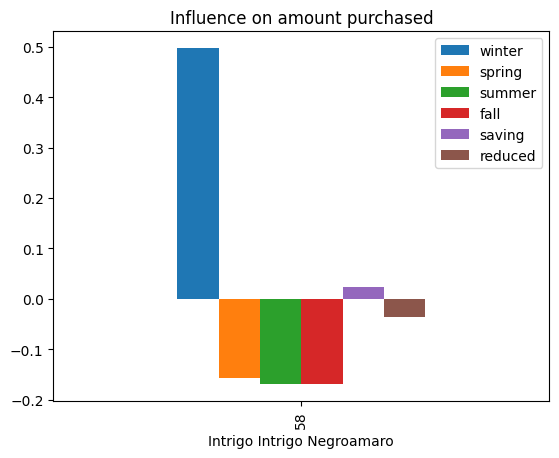

In [134]:
expl[['winter', 'spring', 'summer', 'fall', 'saving', 'reduced']][:1].plot(kind='bar',xlabel=items[expl[['winter', 'spring', 'summer', 'fall', 'saving', 'reduced']][:1].index][0],title='Influence on amount purchased',)